# Live Auction

Recently the human bidders on the site are becoming increasingly frustrated with their inability to win auctions vs. robots. In order to rebuild customer happiness, the company is seeking to eliminate robot bidders from the site.

The goal of this project is to provide Live Auction with a model that will identify and flag bidders if they are a robot and prevent unfair bidding activity.

### Profile of a Robot

My hypothesis is that a robot bidder will have these characteristics:
1. They do lots of bids
2. Wait until the end of the auction
3. Bid in defined increments all the time for a given auction
4. Bid quickly
5. Execute multiple simultaneous bids.

In [10]:
############### Imports ################

# Basic Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Infrastructure
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.utils import resample
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import boto3
import io

In [3]:
############### Bring in Data ############
start_time = time.time()
s3 = boto3.client('s3')

#Bring in Training Data
obj = s3.get_object(Bucket='data-science-project-data', Key='Human_or_Robot/train.csv')
train = pd.read_csv(io.BytesIO(obj['Body'].read()))


# Bring in bids data
obj = s3.get_object(Bucket='data-science-project-data', Key='Human_or_Robot/bids.csv')
bids = pd.read_csv(io.BytesIO(obj['Body'].read()))

print("-- Execution time: %s seconds ---" % (time.time() - start_time))


-- Execution time: 22.536537408828735 seconds ---


## Exploratory Data Analysis

### Train Data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 4 columns):
bidder_id          2013 non-null object
payment_account    2013 non-null object
address            2013 non-null object
outcome            2013 non-null float64
dtypes: float64(1), object(3)
memory usage: 63.0+ KB


In [47]:
#Serious class imbalance. Will need to deal with this when join the tables from the bids data onto this to create a final feature dataset
train['outcome'].value_counts()

0.0    1910
1.0     103
Name: outcome, dtype: int64

### Bids Data

In [41]:
bids.head(10)

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3
5,5,e8291466de91b0eb4e1515143c7f74dexy2yr,3vi4t,mobile,phone7,9759243157894736,ru,91.107.221.27,vasstdc27m7nks3
6,6,eef4c687daf977f64fc1d08675c44444raj3s,kjlzx,mobile,phone2,9759243210526315,th,152.235.155.159,j9nl1xmo6fqhcc6
7,7,ab056855c9ca9d36390feae1fa485883issyg,f5f6k,home goods,phone8,9759243210526315,id,3.210.112.183,hnt6hu93a3z1cpc
8,8,d600dc03b11e7d782e1e4dae091b084a1h5ch,h7jjx,home goods,phone9,9759243210526315,th,103.64.157.225,vasstdc27m7nks3
9,9,a58ace8b671a7531c88814bc86b2a34cf0crb,3zpkj,sporting goods,phone4,9759243210526315,za,123.28.123.226,vasstdc27m7nks3


In [9]:
bids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7656334 entries, 0 to 7656333
Data columns (total 9 columns):
bid_id         int64
bidder_id      object
auction        object
merchandise    object
device         object
time           int64
country        object
ip             object
url            object
dtypes: int64(2), object(7)
memory usage: 525.7+ MB


-- Execution time: 28.38271474838257 seconds ---


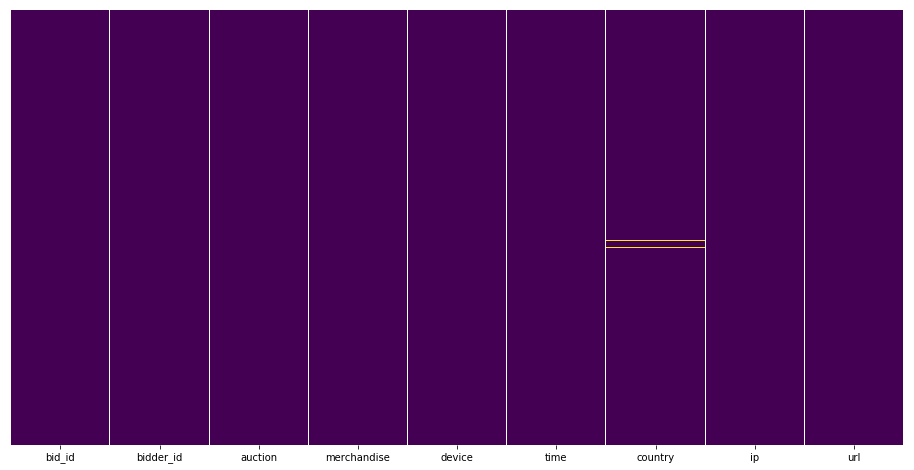

In [13]:
# Is there any missing data?
plt.figure(figsize=(16,8))
start_time = time.time()
sns.heatmap(bids.isnull(), yticklabels=False, cbar=False, cmap='viridis')
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

Country is only missing a little. The rest is filled in.

### Time Feature Engineering

In [7]:
#Find Earlierest Time stamp
sorted_bids = bids.sort_values(by=['time'], ascending=True)
sorted_bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
2351187,2351187,76218e14c379c12d599dae9e1c00b61a3i5b2,6hpvy,sporting goods,phone1161,9631916842105263,cz,121.169.96.51,f33fl83l4vrg6is
2351202,2351202,29c103503e1d6ace5626fb07a5ab0dafrtjvs,wpee4,jewelry,phone412,9631916842105263,ru,63.82.37.102,via8q041tf3xrke
2351201,2351201,0ea62aaa9c3ffcc6db584cb69c1f6c4bcripp,b6zck,mobile,phone99,9631916842105263,lt,181.144.42.116,vasstdc27m7nks3
2351200,2351200,6e178db6d17d21aa88aaca5bf15c2761lc500,jqx39,jewelry,phone99,9631916842105263,sa,174.12.78.255,omwhmwzvrn6ycq6
2351199,2351199,b7c4f67613c2af7e544f01359d4fccc7l5f7y,du967,office equipment,phone348,9631916842105263,tr,21.10.208.37,vasstdc27m7nks3


In [8]:
#Find Time Difference, the smallest unit
sorted_bids['Time Shift'] = sorted_bids['time'].diff()
time_diff = sorted_bids['Time Shift'].value_counts().to_frame().reset_index()

In [9]:
#This is to be able to fully see the value instead of the exponent version
time_diff['converted'] = time_diff['index'].apply(lambda x: '%.3f' % x)
time_diff

,index,Time Shift,converted
0,0.000000e+00,6879805,0.000
1,5.263158e+07,734681,52631579.000
2,5.263158e+07,40817,52631578.000
3,1.052632e+08,904,105263158.000
4,1.052632e+08,105,105263157.000
5,1.578947e+08,10,157894737.000
6,1.578947e+08,3,157894736.000
7,5.002111e+13,2,50021105263158.000
8,5.263158e+08,1,526315790.000
9,4.210526e+08,1,421052632.000


In [25]:
#Create function to time into a real time stamp. Assuming min_time_diff is a second.
def convert_time(time):
    min_time_diff = 52631579
    #Time in seconds of 1/1/2010 12:00AM since 1970
    init_seconds = 1262347200
    #Minimum value from dataset
    min_time = 9631916842105263

    b = init_seconds - (1/min_time_diff)*min_time
    timestamp = (1/min_time_diff)*time + b
    return datetime.datetime.fromtimestamp(timestamp)
    

In [27]:
#Test
convert_time(9759243157894736)

datetime.datetime(2010, 1, 29, 11, 59, 59, 997581)

In [28]:
#Create Subset to test quickly
bid_subset = bids.head()

In [29]:
#Lets build a new column and see if accurate
bid_subset['Converted Time'] = bid_subset['time'].apply(lambda x: convert_time(x))

In [31]:
bid_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
bid_id            5 non-null int64
bidder_id         5 non-null object
auction           5 non-null object
merchandise       5 non-null object
device            5 non-null object
time              5 non-null int64
country           5 non-null object
ip                5 non-null object
url               5 non-null object
Converted Time    5 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 480.0+ bytes


In [32]:
#Apply to entire dataset
bids['Converted Time'] = bids['time'].apply(lambda x: convert_time(x))

### Bids Features Engineering

In [5]:
#### Create aggregate dataframe ########

start_time = time.time()
# Create bidder aggregation
bidder_aggregate = bids.groupby(['bidder_id'])['bid_id'].count().to_frame()
bidder_aggregate.columns = ['Total Bids']

# Add other columns
bidder_aggregate['Total Auctions'] = bids.groupby(['bidder_id'])['auction'].nunique()
bidder_aggregate['Number of Merchandise'] = bids.groupby(['bidder_id'])['merchandise'].nunique()
bidder_aggregate['Number of Device'] = bids.groupby(['bidder_id'])['device'].nunique()
bidder_aggregate['Number of IPs'] = bids.groupby(['bidder_id'])['ip'].nunique()
bidder_aggregate['Number of URLs'] = bids.groupby(['bidder_id'])['url'].nunique()

print("-- Execution time: %s seconds ---" % (time.time() - start_time))

-- Execution time: 54.16590142250061 seconds ---


In [6]:
bidder_aggregate.head()

,Total Bids,Total Auctions,Number of Merchandise,Number of Device,Number of IPs,Number of URLs
bidder_id,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1
002d229ffb247009810828f648afc2ef593rb,2,1,1,2,1,1
0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,3,1,3,3,2
00486a11dff552c4bd7696265724ff81yeo9v,20,13,1,8,10,7


#### Bidder- Auction

Goal: What I want to pull out of this section (By bidder)
1. Min Mean Time per bid
2. Max Mean time per bid
3. Mean mean time per bid
4. Mean number of bids per auction
5. Count Auction Wins (Last bid equal Auction last bid)
6. Mean Time Particpation
7. Median Time particpation
8. Max Time particpation
9. Min Time particpation
10. Mean started ratio
11. Median started ratio
12. Max Started ratio
13. Min Started ratio



In [38]:
#Create this dataframe
bidder_auction = bids.groupby(['bidder_id','auction'])['Converted Time'].min().to_frame()
bidder_auction.columns = ['First Bid Time']
bidder_auction['Last Bid Time'] = bids.groupby(['bidder_id','auction'])['Converted Time'].max().to_frame()
bidder_auction['Bid Time Difference'] = bidder_auction['Last Bid Time'] - bidder_auction['First Bid Time']
bidder_auction['Number of Bids'] = bids.groupby(['bidder_id','auction'])['time'].count().to_frame()
bidder_auction['Mean Time per Bid'] = bidder_auction['Bid Time Difference']/bidder_auction['Number of Bids']


In [39]:
bidder_auction.head(20)

First Bid Time  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-17 20:48:55.998586   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 03:35:17.997438   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-17 11:21:44.998620   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-16 14:31:15.998695   
                                      efh5o   2010-01-17 18:51:31.998593   
                                      obbny   2010-01-03 06:45:33.999846   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   2010-01-01 15:49:21.999986   
                                      9ul86   2010-01-02 06:35:38.999933   
                                      cci6c   2010-01-03 00:56:10.999867   
                                      drdr4   2010-01-15 13:02:53.998786   
                                      eaz7i   2010-01-03 22:59:44.999788   
                                      gst86   2010-01-01 19:30:33.999973   
                                      lx0hm   2010-01-02 20:04:19.999884   
                                      lz5gg   2010-01-03 23:01:57.999787   
                                      nf1v1   2010-01-15 13:15:41.998786   
                                      no958   2010-01-01 15:47:53.999986   
                                      opnq4   2010-01-04 00:02:18.999784   
                                      qvhei   2010-01-17 08:35:51.998630   
                                      ss2rr   2010-01-18 10:45:20.998536   
0051aef3fdeacdadba664b9b3b07e04e4coc6 d2q2z   2010-01-29 12:08:55.997580   

                                                           Last Bid Time  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-17 20:48:55.998586   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 03:35:19.997438   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-17 11:21:44.998620   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-16 14:31:15.998695   
                                      efh5o   2010-01-17 18:51:31.998593   
                                      obbny   2010-01-03 06:45:33.999846   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   2010-01-02 12:11:55.999913   
                                      9ul86   2010-01-02 06:35:38.999933   
                                      cci6c   2010-01-03 00:56:10.999867   
                                      drdr4   2010-01-15 14:49:42.998780   
                                      eaz7i   2010-01-03 22:59:44.999788   
                                      gst86   2010-01-03 08:55:27.999838   
                                      lx0hm   2010-01-02 20:04:19.999884   
                                      lz5gg   2010-01-04 08:11:20.999754   
                                      nf1v1   2010-01-15 13:15:41.998786   
                                      no958   2010-01-02 20:04:12.999884   
                                      opnq4   2010-01-04 07:14:23.999758   
                                      qvhei   2010-01-17 08:35:51.998630   
                                      ss2rr   2010-01-18 10:45:20.998536   
0051aef3fdeacdadba664b9b3b07e04e4coc6 d2q2z   2010-01-30 05:45:25.997517   

                                                 Bid Time Difference  \
bidder_id                             auction                          
001068c415025a009fee375a12cff4fcnht8y 4ifac          0 days 00:00:00   
002d229ffb247009810828f648afc2ef593rb 2tdw2          0 days 00:00:02   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny          0 days 00:00:00   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6          0 days 00:00:00   
                                      efh5o          0 days 00:00:00   
                                      obbny          0 days 00:00:00   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   0 days 20:22:33.999927   
                                      9ul86          0 days 00:0

#### Auction

Want to join this datafram to the bidd_acution dataframe

In [69]:
# Create Auction Dataframe
auction = bids.groupby(['auction'])['Converted Time'].min().to_frame()
auction.columns = ['Auction Started']

#Create other columns
auction['Auction Ended'] = bids.groupby(['auction'])['Converted Time'].max().to_frame()
auction['Auction Time Difference'] = auction['Auction Ended'] - auction['Auction Started']
auction['Number of Bidders'] = bids.groupby(['auction'])['bidder_id'].nunique().to_frame()
#auction['Number of Bids'] = bids.groupby(['auction'])['bidder_id'].count().to_frame()

In [70]:
auction.head(10)

,Auction Started,Auction Ended,Auction Time Difference,Number of Bidders
auction,,,,
00270,2010-01-16 06:18:47.998724,2010-01-18 11:57:04.998531,2 days 05:38:16.999807,26
008vv,2010-01-29 12:39:58.997578,2010-01-29 18:05:25.997559,0 days 05:25:26.999981,2
00cwr,2010-01-15 12:19:30.998789,2010-01-16 04:07:54.998732,0 days 15:48:23.999943,11
00do0,2010-01-29 12:25:32.997579,2010-01-29 15:16:58.997569,0 days 02:51:25.999990,2
00hjy,2010-01-29 12:52:56.997577,2010-02-01 11:08:52.997324,2 days 22:15:55.999747,20
00hm5,2010-01-01 12:25:02.999998,2010-01-04 11:59:21.999741,2 days 23:34:18.999743,6
00llo,2010-01-30 00:56:16.997534,2010-01-31 03:54:43.997437,1 days 02:58:26.999903,11
00mip,2010-01-30 12:42:33.997492,2010-01-30 12:42:33.997492,0 days 00:00:00,1
00p4a,2010-01-30 14:06:24.997487,2010-01-30 14:06:24.997487,0 days 00:00:00,1


In [71]:
#The mean auction lasts 5 days This seems plausible with reverse engineering the time.
auction['Auction Time Difference'].mean()

Timedelta('5 days 10:48:09.695629')

In [72]:
#Join Auction with Bidder_auction
bidder_auction_full = bidder_auction.join(auction, how='inner')
bidder_auction_full.head(20)

First Bid Time  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-17 20:48:55.998586   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 03:35:17.997438   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-17 11:21:44.998620   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-16 14:31:15.998695   
                                      efh5o   2010-01-17 18:51:31.998593   
                                      obbny   2010-01-03 06:45:33.999846   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   2010-01-01 15:49:21.999986   
                                      9ul86   2010-01-02 06:35:38.999933   
                                      cci6c   2010-01-03 00:56:10.999867   
                                      drdr4   2010-01-15 13:02:53.998786   
                                      eaz7i   2010-01-03 22:59:44.999788   
                                      gst86   2010-01-01 19:30:33.999973   
                                      lx0hm   2010-01-02 20:04:19.999884   
                                      lz5gg   2010-01-03 23:01:57.999787   
                                      nf1v1   2010-01-15 13:15:41.998786   
                                      no958   2010-01-01 15:47:53.999986   
                                      opnq4   2010-01-04 00:02:18.999784   
                                      qvhei   2010-01-17 08:35:51.998630   
                                      ss2rr   2010-01-18 10:45:20.998536   
0051aef3fdeacdadba664b9b3b07e04e4coc6 d2q2z   2010-01-29 12:08:55.997580   

                                                           Last Bid Time  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-17 20:48:55.998586   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 03:35:19.997438   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-17 11:21:44.998620   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-16 14:31:15.998695   
                                      efh5o   2010-01-17 18:51:31.998593   
                                      obbny   2010-01-03 06:45:33.999846   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   2010-01-02 12:11:55.999913   
                                      9ul86   2010-01-02 06:35:38.999933   
                                      cci6c   2010-01-03 00:56:10.999867   
                                      drdr4   2010-01-15 14:49:42.998780   
                                      eaz7i   2010-01-03 22:59:44.999788   
                                      gst86   2010-01-03 08:55:27.999838   
                                      lx0hm   2010-01-02 20:04:19.999884   
                                      lz5gg   2010-01-04 08:11:20.999754   
                                      nf1v1   2010-01-15 13:15:41.998786   
                                      no958   2010-01-02 20:04:12.999884   
                                      opnq4   2010-01-04 07:14:23.999758   
                                      qvhei   2010-01-17 08:35:51.998630   
                                      ss2rr   2010-01-18 10:45:20.998536   
0051aef3fdeacdadba664b9b3b07e04e4coc6 d2q2z   2010-01-30 05:45:25.997517   

                                                 Bid Time Difference  \
bidder_id                             auction                          
001068c415025a009fee375a12cff4fcnht8y 4ifac          0 days 00:00:00   
002d229ffb247009810828f648afc2ef593rb 2tdw2          0 days 00:00:02   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny          0 days 00:00:00   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6          0 days 00:00:00   
                                      efh5o          0 days 00:00:00   
                                      obbny          0 days 00:00:00   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   0 days 20:22:33.999927   
                                      9ul86          0 days 00:0

In [74]:
#Add More Features

#Particpation measure. How much of the auction particpated in (time)
bidder_auction_full['Time Particpation'] = (((bidder_auction_full['Auction Ended'] 
                                                 - bidder_auction_full['First Bid Time'])/bidder_auction_full['Auction Time Difference']))*100

#Started ratio (When got in the higher the number the later)
bidder_auction_full['Started Ratio'] = (((bidder_auction_full['First Bid Time'] 
                                                 - bidder_auction_full['Auction Started'])/bidder_auction_full['Auction Time Difference']))*100

#Won Auction
bidder_auction_full['Won Auction'] = bidder_auction_full['Last Bid Time']==bidder_auction_full['Auction Ended']
bidder_auction_full.head(10)


First Bid Time  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-17 20:48:55.998586   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 03:35:17.997438   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-17 11:21:44.998620   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-16 14:31:15.998695   
                                      efh5o   2010-01-17 18:51:31.998593   
                                      obbny   2010-01-03 06:45:33.999846   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   2010-01-01 15:49:21.999986   
                                      9ul86   2010-01-02 06:35:38.999933   
                                      cci6c   2010-01-03 00:56:10.999867   
                                      drdr4   2010-01-15 13:02:53.998786   

                                                           Last Bid Time  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-17 20:48:55.998586   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 03:35:19.997438   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-17 11:21:44.998620   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-16 14:31:15.998695   
                                      efh5o   2010-01-17 18:51:31.998593   
                                      obbny   2010-01-03 06:45:33.999846   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   2010-01-02 12:11:55.999913   
                                      9ul86   2010-01-02 06:35:38.999933   
                                      cci6c   2010-01-03 00:56:10.999867   
                                      drdr4   2010-01-15 14:49:42.998780   

                                              Bid Time Difference  \
bidder_id                             auction                       
001068c415025a009fee375a12cff4fcnht8y 4ifac              00:00:00   
002d229ffb247009810828f648afc2ef593rb 2tdw2              00:00:02   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny              00:00:00   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6              00:00:00   
                                      efh5o              00:00:00   
                                      obbny              00:00:00   
00486a11dff552c4bd7696265724ff81yeo9v 6plix       20:22:33.999927   
                                      9ul86              00:00:00   
                                      cci6c              00:00:00   
                                      drdr4       01:46:48.999994   

                                               Number of Bids  \
bidder_id                             auction                   
001068c415025a009fee375a12cff4fcnht8y 4ifac                 1   
002d229ffb247009810828f648afc2ef593rb 2tdw2                 2   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny                 1   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6                 1   
                                      efh5o                 1   
                                      obbny                 1   
00486a11dff552c4bd7696265724ff81yeo9v 6plix                 2   
                                      9ul86                 1   
                                      cci6c                 1   
                                      drdr4                 2   

                                              Mean Time per Bid  \
bidder_id                             auction                     
001068c415025a009fee375a12cff4fcnht8y 4ifac            00:00:00   
002d229ffb247009810828f648afc2ef593rb 2tdw2            00:00:01   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny            00:00:00   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6            00:00:00   
                                      efh5o            00:00:00   
                                      obbny            00:00:00   
00486a11dff552c4bd7696265724ff81yeo9v 6plix     10:11:16.999963   
                   

In [125]:
#Want to be able to do grouping by some time period. To see how many auctions occured in that time span. Then could do group by bidder, time period,
# and then count how many auctions are going on. This will tell us how many simultaneous they are bidding on.